# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<font color='blue'>Импортирую библиотеки</font>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

<font color='blue'>Читаю файл, разделяя склееные строки</font>

In [2]:
try:
    flats = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    flats = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv')
 

<font color='blue'>Вывожу информацию о датасете</font>

In [3]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

<font color='blue'>Довольно много данных, которые нужно будет исправлять с object на int, также есть пропущенные значения. Выведу первые 10 строк датасета</font>

In [4]:
pd.set_option('display.max_columns', None)
flats.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


<font color='blue'>Проверяю размах значений числовых столбцов с помощью команды describe</font>

In [6]:
flats.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


<font color='blue'>Строю гистограмму flats. Использую plt.show(), чтобы убрать AxesSubplot:</font>

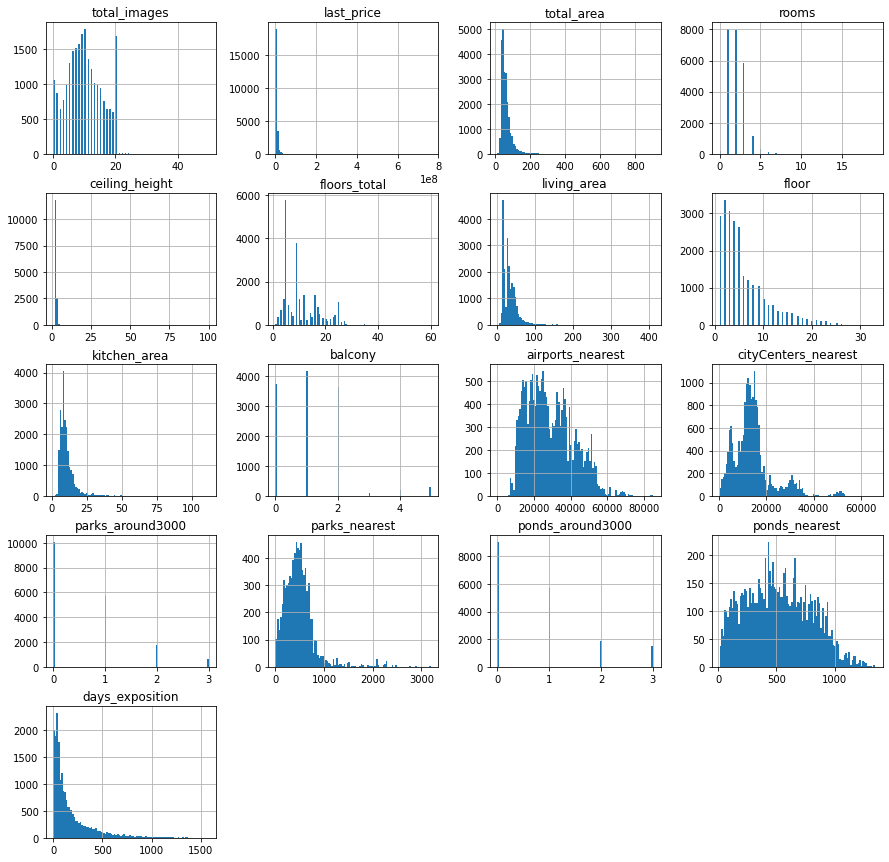

In [7]:
flats.hist(bins = 100, figsize = (15,15))
plt.show()

<font color='blue'></font>

<div class="alert alert-info">
    <b>total_images:</b> Больше всего объявлений с фото от 0 до 20 (распределение близко к нормальному), есть выброс в районе 20 штук.
    <br/>
<b>rooms:</b> Видно, что больше всего продается одно-, двух- и трехкомнатных квартир, но график по умолчанию не очень нагляден.
    <br/>
<b>floor:</b> Тут всё похоже на правду, даже нет выбросов, больше всего продаётся квартир на 1-5 этажах, меньше на 6-10, ещё меньше на 11-25, остальное - единичные значения. Наверное, активно продают квартиры в старых пятиэтажках
<br>Столбец <b>last_price</b> очень размашистый, видно, что основная часть значений расположилась в начале графика. Значит, есть выбросы в графе цены
        <br/>
<b>total_area</b> выглядит более приемлемо, видно, что наиболее распространенные значения заканчиваются в районе 200
    <br/>
<b>ceiling_height</b> - основная чать значений лежит в районе 3-5м, есть выбросы до 100м
   <br/>
<b>floors_total</b> - тут всё ок, больше всего продают квартир в 5- и 9-этажках
    <br/>
<b>living_area</b>, <b>kitchen_area</b> - тут похоже на нормальное распределение, но судя по размаху графику, есть выбросы
    <br/>
<b>balcony</b> - в основном в квартирах 1 балкон или нет балконов совсем
    <br/>  
<b>airports_nearest</b>, <b>cityCenters_nearest</b>, <b>parks_nearest</b>, <b>ponds_nearest</b> - тут приближенные к нормальным распределения
    <br/>
<b>parks_around3000</b>, <b>ponds_around3000</b> - в основном либо нет парков и прудов поблизости, либо сразу 2 или 3. Странно, что почти нет 1
    <br/>
<b>days_exposition</b> - нормальное распределение, выбросы есть (а может, это просто очень долгие продажи)
    															
</div>

### Предобработка данных

<font color='blue'>Посмотрим, сколько пропущенных значений в каждом стоблце</font>

In [8]:
flats.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

<font color='blue'>
Есть столбцы, в которых пропуски можно заполнить медианным значением по какому-либо признаку:
<b>living_area</b> (например, по количеству комнат в квартире), <b>ceiling_height</b> (по количеству этажей в доме)

   <br/>

<b>is_apartment</b> - там, где пропущено, можно поставить False, это не апартаменты
    
   <br/> 
В столбце <b>balcony</b> пропущенные значения, скорее всего, значат, что балконов в квартире нет, можно заменить на 0.
   <br/>
    
Примерно та же история со столбцами <b>parks_around3000</b> и <b>ponds_around3000</b> - если значение в этих столбцах пропущено, значит, парков и прудов в радиусе 3км у этой квартиры нет, можно заменить на 0
    
   <br/> 
В <b>locality_name</b> можно попробовать заполнить те строки, где расстояние до центра меньше определенного количества километров
<br/> 
    
<b>floors_total</b> - пропущенных значений немного, но удалять совсем строки не хочется, думаю, можно заменить значением этажа квартиры <b>floor</b>
    <br/>  

<b>kitchen_area</b> можно примерно вычислить из <b>total_area</b> и <b>living_area</b>. Думаю, можно считать, что она составляет примерно половину нежилой площади квартиры.
   <br/>   
<b>days_exposition</b> - неизвестно, как можно заполнить здесь значения, хотя очень хочется)) но нам известен только день публикации объявления, а день снятия - нет.
    
<br/>
Пропущенные значения в столбцах <b>airports_nearest</b> (расстояние до ближайшего аэропорта), <b>cityCenters_nearest</b>, <b>parks_nearest</b>, <b>ponds_nearest</b>, наверное, никак корректно не заполнить, оставим пропущенные значения
(пропущенные значения в <b>cityCenters_nearest</b>, например, могут значить, что это другой населенный пункт)


</font>

<font color='blue'>1. Начну с заполнения столбца <b>living_area</b>. Вывожу первые 10 строк:</font>

In [9]:
flats['living_area'].head(10)

0    51.00
1    18.60
2    34.30
3      NaN
4    32.00
5    14.40
6    10.60
7      NaN
8    15.43
9    43.60
Name: living_area, dtype: float64

<font color='blue'>Заменяю значения в living_area на медианные в зависимости от того, сколько комнат в квартире</font>

In [11]:
for t in flats['rooms'].unique():
    flats.loc[(flats['rooms'] == t) & (flats['living_area'].isna()), 'living_area'] = flats.loc[(flats['rooms'] == t), 'living_area'].median()

<font color='blue'>Проверяю, что получилось:</font>

In [12]:
flats['living_area'].head(10)

0    51.00
1    18.60
2    34.30
3    45.00
4    32.00
5    14.40
6    10.60
7    30.50
8    15.43
9    43.60
Name: living_area, dtype: float64

In [13]:
flats['living_area'].isna().sum()

0

In [14]:
flats['living_area'].describe()

count    23699.000000
mean        34.321982
std         21.700627
min          2.000000
25%         18.400000
50%         30.300000
75%         42.700000
max        409.700000
Name: living_area, dtype: float64

<font color='blue'>Строю гистограмму</font>

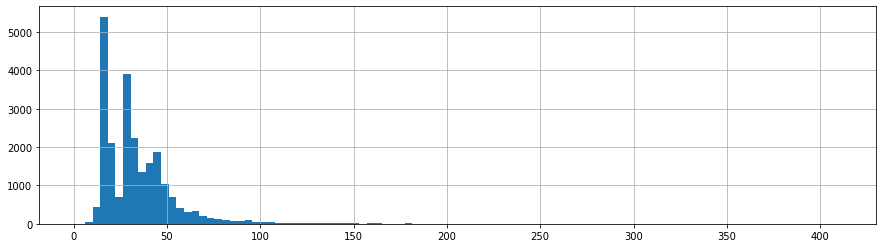

In [15]:
flats['living_area'].hist(bins=100, figsize = (15,4))
plt.show()

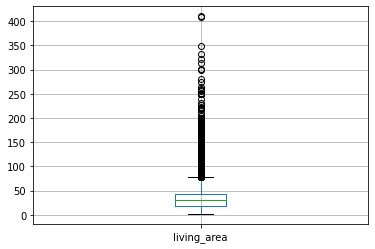

In [16]:
flats.boxplot('living_area')
plt.show()

<font color='blue'>Есть два выброса в районе 18 и 30 кв.м. и провал примерно на 25 кв.м. Также из describe видно, что есть квартиры с жилой площадью 2 кв.м. и 409 кв.м., интересно было бы на них посмотреть</font>

In [17]:
flats.loc[flats['living_area'] > 400]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5358,20,65000000.0,590.0,2019-02-14T00:00:00,15,3.5,6.0,409.0,3,NaN,False,False,100.0,NaN,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
19540,8,420000000.0,900.0,2017-12-06T00:00:00,12,2.8,25.0,409.7,25,NaN,False,False,112.0,NaN,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


<font color='blue'>Но тут всё похоже на правду, и количество комнат, и цена. Наверное, действительно, существуют такие квартиры</font>

In [18]:
flats.loc[flats['living_area'] < 5]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3242,7,4440000.0,41.0,2017-07-02T00:00:00,1,NaN,17.0,3.0,17,NaN,False,False,11.0,NaN,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
13915,20,6350000.0,52.0,2018-02-06T00:00:00,2,3.0,6.0,2.0,2,NaN,False,False,9.0,NaN,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
21758,0,2330000.0,23.0,2018-01-01T00:00:00,0,NaN,24.0,2.0,22,NaN,True,False,NaN,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0
23574,14,64990000.0,139.0,2015-11-24T00:00:00,3,3.0,8.0,3.0,8,NaN,False,False,16.0,1.0,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0


<font color='blue'>Трешка с площадью 139, но с жилой - 3, почти за 65 миллионов, очень интрересно)</font>

<font color='blue'>2. Разбираемся с <b>kitchen_area</b>. ~Для этого нужно сначала подготовить столбец <b>total_area</b>, перевести его в числовой формат.~
</font>

In [19]:
#flats['total_area'] = pd.to_numeric(flats['total_area'])
flats['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

In [20]:
flats['total_area'].isna().sum()

0

<font color='blue'>Проверяю, есть ли строки с <b>living_area</b> больше чем <b>total_area</b>.
</font>

In [21]:
flats.loc[flats['total_area'] < flats['living_area'], ['total_area', 'living_area']]

,total_area,living_area
1595,62.4,63.600
3374,41.5,45.000
8976,41.2,45.000
9795,42.0,45.000
9964,49.5,63.600
11814,42.0,45.000
11977,62.0,63.600
12040,15.0,17.600
12129,30.0,30.500
12186,71.4,91.785


<font color='blue'>Есть, и немало. Будем считать, что здесь в этих столбцах просто перепутаны местами значения. Поменяем их.
</font>

In [22]:
flats_temp = flats[['total_area', 'living_area']]
flats['living_area'], flats['total_area'] = flats_temp.min(axis=1), flats_temp.max(axis=1)

flats.loc[flats['total_area'] < flats['living_area'], ['total_area', 'living_area']]

,total_area,living_area


<div class="alert alert-info">
Посмотрим на столбец <b>kitchen_area</b>
</div>

In [23]:
flats['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

<font color='blue'>Теперь рассчитаю площадь кухни как (<b>total_area</b> - <b>living_area</b>)/2</font>

In [24]:
flats['kitchen_area'] =  flats['kitchen_area'].fillna((flats['total_area'] - flats['living_area'])/2)

In [25]:
flats['kitchen_area'].isna().sum()

0

In [26]:
flats['kitchen_area'].describe()

count    23699.000000
mean        10.763806
std          7.105363
min          0.000000
25%          7.000000
50%          9.200000
75%         12.000000
max        238.250000
Name: kitchen_area, dtype: float64

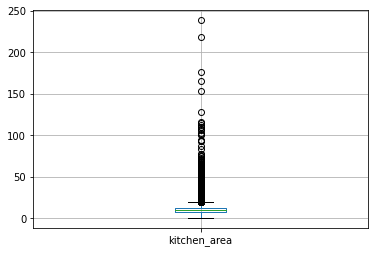

In [27]:
flats.boxplot('kitchen_area')
plt.show()

<font color='blue'>Много выбросов, посмотрим, что это за квартиры с кухнями больше 100м</font>

In [28]:
flats.loc[flats['kitchen_area'] > 100, ['total_area', 'living_area', 'kitchen_area']]

,total_area,living_area,kitchen_area
581,365.0,145.000,110.0000
1388,399.0,91.785,153.6075
2243,304.0,91.785,106.1075
2489,255.0,153.900,100.7000
5873,400.0,145.000,127.5000
7558,251.0,45.000,103.0000
7674,380.0,150.000,115.0000
9826,494.1,17.600,238.2500
10181,295.0,63.600,115.7000
10684,364.7,145.000,109.8500


<font color='blue'>Это, конечно, очень большие площади для кухни, но вроде бы не аномальные. Общая и жилая площадь таких квартир тоже большие. Не будем ничего исправлять</font>

<font color='blue'>3. Разберемся с балконами</font>

In [29]:
flats['balcony'].head(10)

0    NaN
1    2.0
2    0.0
3    0.0
4    NaN
5    NaN
6    1.0
7    2.0
8    NaN
9    2.0
Name: balcony, dtype: float64

<font color='blue'>Значения Nan в этом столбце можно заменить на 0</font>

In [30]:
flats.loc[(flats['balcony'].isna()), 'balcony'] = 0

In [31]:
flats['balcony'] = flats['balcony'].astype('int')

In [32]:
flats['balcony'].head(10)

0    0
1    2
2    0
3    0
4    0
5    0
6    1
7    2
8    0
9    2
Name: balcony, dtype: int64

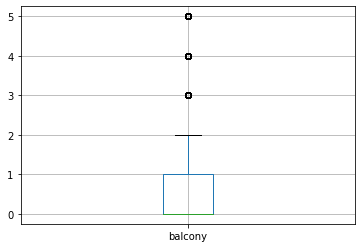

In [33]:
flats.boxplot('balcony')
plt.show()

<font color='blue'>В основном, конечно, балконов 0 или 1, редко 2. 3 тоже можно считать нормой для больших квартир. Посмотрим на выбросы 4 и 5</font>

In [34]:
flats.loc[flats['balcony'] >= 4, ['total_area', 'rooms', 'balcony']].head(10)

,total_area,rooms,balcony
41,74.0,3,5
42,161.8,4,5
116,97.2,3,5
121,180.0,3,4
250,51.7,2,4
263,140.6,2,4
267,120.0,3,5
311,86.0,3,5
336,79.0,3,5
371,65.0,2,5


<font color='blue'>Неплохо - в двушке 5 балконов. Такого, конечно, быть не может, но как это исправлять - даже не знаю. Придется удалить строки с некорректными данными. Выберем квартиры меньше 100м, у которых балконов больше 3, и удалим.</font>

In [35]:
flats = flats.query('not((total_area < 100) and (balcony > 3))')

In [36]:
flats.loc[(flats['total_area'] < 100)&(flats['balcony'] > 3)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


<font color='blue'>4. Посмотрим на столбцы <b>parks_around3000</b> и <b>ponds_around3000</b></font>

In [37]:
flats['parks_around3000'].unique()

array([ 1.,  0.,  2., nan,  3.])

<font color='blue'>Заменяю значения Nan в этих столбцах на 0 и меняю тип на int</font>

In [38]:
flats['parks_around3000'] = flats['parks_around3000'].fillna('0')
flats['parks_around3000'] = flats['parks_around3000'].astype('int')

In [39]:
flats['parks_around3000'].head()

0    1
1    0
2    1
3    2
4    2
Name: parks_around3000, dtype: int64

In [40]:
flats['ponds_around3000'].unique()

array([ 2.,  0.,  3.,  1., nan])

In [41]:
flats['ponds_around3000'] = flats['ponds_around3000'].fillna('0')
flats['ponds_around3000'] = flats['ponds_around3000'].astype('int')

In [42]:
flats['ponds_around3000'].head()

0    2
1    0
2    2
3    3
4    1
Name: ponds_around3000, dtype: int64

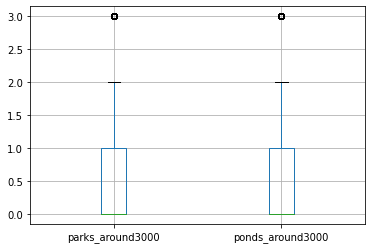

In [43]:
flats.boxplot(['parks_around3000','ponds_around3000'])
plt.show()

<font color='blue'>5. Заменим пропущенные значения в столбце <b>is_apartment</b></font>

In [44]:
flats['is_apartment'].isna().sum()

20596

<font color='blue'> Так как это булево значение, заменяем Nan на False</font>

In [45]:
flats['is_apartment'] = flats['is_apartment'].fillna(value = 'False')

In [46]:
flats['is_apartment'].isna().sum()

0

<font color='blue'>6. Рассмотрим столбец <b>floors_total</b></font>

In [47]:
flats['floors_total'].describe()

count    23215.000000
mean        10.638122
std          6.591892
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

<font color='blue'>Пропущенные значения</font>

In [48]:
flats['floors_total'].isna().sum()

86

<font color='blue'>Их немного, заменим значение в столбце <b>floors_total</b> на значение в столбце <b>floor</b> и переведем в формат int</font>

In [49]:
flats['floors_total'] = flats['floors_total'].fillna(value = flats['floor'])
    
flats['floors_total'] = flats['floors_total'].astype('int')

In [50]:
flats['floors_total'].head()

0    16
1    11
2     5
3    14
4    14
Name: floors_total, dtype: int64

In [51]:
flats['floor'].head()

0     8
1     1
2     4
3     9
4    13
Name: floor, dtype: int64

<font color='blue'>7. Теперь заполнение столбца <b>ceiling_height</b>. Если предположить, что дома определённой этажности имеют одну высоту потолков, то пропущенные значения можно заполнить медианным по количеству этажей дома</font>

In [52]:
flats['ceiling_height'].describe()

count    14207.000000
mean         2.761124
std          0.913722
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         32.000000
Name: ceiling_height, dtype: float64

<div class="alert alert-info">
Для удобства округлим до 2 знаков после запятой
</div>

In [53]:
flats['ceiling_height'] = round(flats['ceiling_height'],2)

In [54]:
flats['ceiling_height'].head()

0    2.70
1     NaN
2     NaN
3     NaN
4    3.03
Name: ceiling_height, dtype: float64

<font color='blue'>Для каждого значения высотности дома вычислим медианную высоту помещений и заполним этими значениями пропущенные ячейки</font>

In [55]:
for t in flats['floors_total'].unique():
    flats.loc[(flats['floors_total'] == t) & (flats['ceiling_height'].isna()), 'ceiling_height'] = \
    flats.loc[(flats['floors_total'] == t), 'ceiling_height'].mean()

In [56]:
flats['ceiling_height'].isna().sum()

1

In [57]:
flats.loc[flats['ceiling_height'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
11575,9,9900000.0,101.0,2016-04-28T00:00:00,3,NaN,33,53.0,32,False,False,False,21.0,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,53.0


<font color='blue'>Осталась одна незаполненная ячейка, так как больше нет домов с таким же количеством этажей. Заполню её медианным значением по всему столбцу</font>

In [58]:
flats.loc[11575,'ceiling_height'] = round(flats['ceiling_height'].median(), 2)
flats.loc[11575,'ceiling_height']

2.71

<font color='blue'>Теперь посмотрим слишком большие значения этого столбца</font>

In [59]:
flats.query('ceiling_height >= 25')['ceiling_height'] 

355      25.0
3148     32.0
4643     25.0
4876     27.0
5246     27.0
5669     26.0
6246     25.0
9379     25.0
10773    27.0
11285    25.0
14382    25.0
17857    27.0
18545    25.0
20478    27.0
21377    27.5
21824    27.0
22938    27.0
Name: ceiling_height, dtype: float64

<font color='blue'>В жилом помещении высота потолков должна быть не менее 2,5м, поэтому там, где значения больше 25м, скорее всего просто не поставили запятую. Делим на 10</font>

In [60]:
flats.loc[flats['ceiling_height'] >= 25, 'ceiling_height'] =\
flats.loc[flats['ceiling_height'] >= 25, 'ceiling_height']/10

In [61]:
flats.loc[22938,'ceiling_height']

2.7

<div class="alert alert-info">
Но остались квартиры с потолками 15, 20м, это тоже некорректно. Будем считать, что если даже квартира двухуровневая, общая высота потолков не превышает 7м. Найдем, сколько квартир с потолками >=7м осталось
</div>

In [62]:
flats.loc[flats['ceiling_height'] >= 7, 'ceiling_height'].head()

3474      8.0
5076     24.0
5863      8.3
15061    14.0
15743     8.0
Name: ceiling_height, dtype: float64

<div class="alert alert-info">
Их всего пять, можно от них избавиться
</div>

In [63]:
flats = flats.loc[flats['ceiling_height'] <= 7]

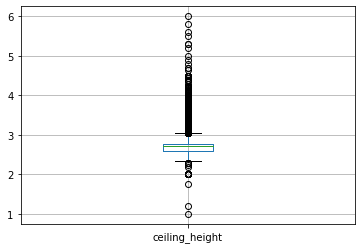

In [64]:
#flats['ceiling_height'].hist()
flats.boxplot('ceiling_height')
plt.show()

<font color='blue'>8. Обратим внимание на столбец <b>locality_name</b></font>

In [65]:
flats['locality_name'].isna().sum()

48

<font color='blue'>Протяжённость города с восток на запад — 32 км, с севера на юг — 52 км, с северо-запада на юго-восток — около 90 км.</font>
<font color='blue'>Можно посмотреть на значение в столбце <b>cityCenters_nearest</b> и где оно меньше 16км, можно утверждать, что эта квартира находится в Санкт-Петербурге</font>


In [66]:
flats['cityCenters_nearest'].describe()

count    17867.000000
mean     14176.022220
std       8630.258349
min        181.000000
25%       9176.000000
50%      13086.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

<font color='blue'>Там, где значение меньше 16км, пишем "Санкт-Петербург", там, где больше - "unknown"</font>

In [69]:
flats.loc[flats['locality_name'].isna() & (flats['cityCenters_nearest'] < 16000), 'locality_name' ] = 'Санкт-Петербург'
flats.loc[flats['locality_name'].isna() &
((flats['cityCenters_nearest'] >= 16000) | flats['cityCenters_nearest'].isna()), 'locality_name' ] = 'Unknown'


In [70]:
flats['locality_name'].isna().sum()

0

In [71]:
flats.loc[:,['cityCenters_nearest', 'locality_name']].head(10)

,cityCenters_nearest,locality_name
0,16028.0,Санкт-Петербург
1,18603.0,посёлок Шушары
2,13933.0,Санкт-Петербург
3,6800.0,Санкт-Петербург
4,8098.0,Санкт-Петербург
5,NaN,городской посёлок Янино-1
6,19143.0,посёлок Парголово
7,11634.0,Санкт-Петербург
8,NaN,посёлок Мурино
9,15008.0,Санкт-Петербург


<font color='blue'>9. Столбец <b>days_exposition</b> показывает, сколько дней объявление висело в поиске до снятия</font>


In [72]:
flats['days_exposition'].describe()

count    20186.000000
mean       180.924799
std        220.012039
min          1.000000
25%         45.000000
50%         95.000000
75%        231.750000
max       1580.000000
Name: days_exposition, dtype: float64

<div class="alert alert-info">
Округлим значения
</div>

In [73]:
flats['days_exposition'] = round(flats['days_exposition'])

In [74]:
flats['days_exposition'].isna().sum()

3107

<div class="alert alert-info">
Пропуски не заполнить, пока оставляем так
</div>

<font color='blue'>Вернемся к столбцу <b>locality_name</b>, найдем неявные дубликаты</font>

In [75]:
flats['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

<font color='blue'>Можно заменить 'поселок'на 'посёлок', городской посёлок' на 'посёлок городского типа', 'садоводческое некоммерческое товарищество' на 'садовое товарищество'</font>

In [76]:
flats['locality_name'] = flats['locality_name'].str.replace('поселок', 'посёлок')

In [77]:
flats['locality_name'] = flats['locality_name'].str.replace('городской посёлок', 'посёлок городского типа')

In [78]:
flats['locality_name'] = flats['locality_name'].str.replace('садоводческое некоммерческое товарищество', 'садовое товарищество')


In [79]:
flats['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары',
       'посёлок городского типа Янино-1', 'посёлок Парголово',
       'посёлок Мурино', 'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин',
       'деревня Кудрово', 'Коммунар', 'Колпино',
       'посёлок городского типа Красный Бор', 'Гатчина',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'посёлок Молодцово',
       'посёлок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'посёлок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'посёлок Торковичи', 'посёлок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёл

<div class="alert alert-info">
Рассмотрим столбец <b>last_price</b>
</div>

In [80]:
flats['last_price'].describe()

count    2.329300e+04
mean     6.533575e+06
std      1.097044e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.735600e+06
max      7.630000e+08
Name: last_price, dtype: float64

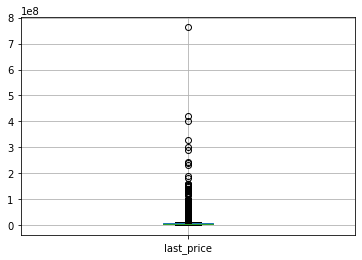

In [82]:
flats.boxplot('last_price')
plt.show()

<div class="alert alert-info">
Посмотрим, что за выброс примерно на 750 млн
</div>

In [83]:
flats.loc[flats['last_price'] > 700000000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12971,19,763000000.0,400.0,2017-09-30T00:00:00,7,2.686796,10,250.0,10,False,False,False,75.0,2,Санкт-Петербург,25108.0,3956.0,1,530.0,3,756.0,33.0


<font color='blue'>Квартира в центре Санкт-Петербурга с 7-ю комнатами и 400кв.м. площади, наверное, должна быть очень дорогая, но не 763млн. Проверим цены похожих квартир</font>

In [84]:
flats.loc[(flats['total_area'] > 300)&(flats['cityCenters_nearest'] < 5000)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
155,8,96000000.0,317.0,2017-07-07T00:00:00,4,3.500000,3,183.0,3,False,False,False,67.00,1,Санкт-Петербург,22673.0,1771.0,2,508.0,3,366.0,62.0
581,20,65000000.0,365.0,2019-03-18T00:00:00,7,2.900000,7,145.0,7,False,False,False,110.00,0,Санкт-Петербург,19827.0,1690.0,3,378.0,3,58.0,NaN
660,3,49950000.0,483.9,2017-10-04T00:00:00,7,3.200000,6,312.5,4,False,False,False,26.40,0,Санкт-Петербург,23079.0,945.0,3,461.0,3,22.0,391.0
1026,20,155000000.0,310.0,2018-10-12T00:00:00,5,5.300000,3,190.0,3,False,False,False,63.00,2,Санкт-Петербург,24899.0,4785.0,0,NaN,1,603.0,NaN
1085,16,75000000.0,323.0,2017-07-10T00:00:00,5,4.000000,5,255.7,4,False,False,False,66.00,0,Санкт-Петербург,23713.0,594.0,3,398.0,2,515.0,259.0
1494,10,65000000.0,364.0,2018-11-27T00:00:00,7,3.900000,6,250.0,3,False,False,False,20.00,0,Санкт-Петербург,21988.0,3254.0,0,NaN,1,689.0,46.0
3117,19,140000000.0,631.0,2019-03-30T00:00:00,7,2.767439,5,145.0,5,False,False,False,60.00,0,Санкт-Петербург,25707.0,4972.0,0,NaN,2,210.0,NaN
4237,1,50000000.0,517.0,2017-10-14T00:00:00,7,2.988594,4,332.0,3,False,False,False,22.00,0,Санкт-Петербург,22835.0,1847.0,2,477.0,2,540.0,NaN
5358,20,65000000.0,590.0,2019-02-14T00:00:00,15,3.500000,6,409.0,3,False,False,False,100.00,0,Санкт-Петербург,24447.0,4666.0,1,767.0,0,NaN,14.0
6183,10,84382000.0,363.1,2018-10-07T00:00:00,3,2.749511,16,45.0,12,False,False,False,31.73,0,Санкт-Петербург,31887.0,4979.0,0,NaN,2,182.0,NaN


<font color='blue'>Есть похожие квартиры по площади, но стоят они в два раза дешевле. Но судя по базе Циан, есть и такие цены на квартиры в центре, поэтому пока не будем считать это аномалией, посмотрим на цену за квадратный метр</font>

<div class="alert alert-info">
Попытаюсь ещё раз рассмотреть столбцы со стоимостью квартиры, количеством комнат и общей площадью
</div>

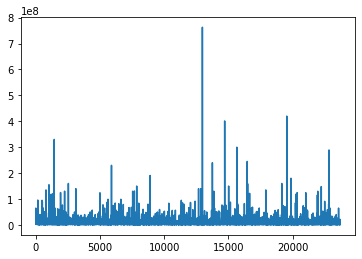

In [85]:
flats['last_price'].plot()
plt.show()

<div class="alert alert-info">
Мне кажется, все выбросы убраны уже. Те, что остались - я бы не стала удалять перед рассмотрением цены квадратного метра
</div>

<div class="alert alert-info">
Теперь количество комнат
</div>

In [86]:
flats['rooms'].describe()

count    23293.000000
mean         2.063925
std          1.082224
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

<div class="alert alert-info">
Рассмотрим квартиры с количеством комнат больше 10 вместе со столбцами общей и жилой площади
</div>

In [87]:
flats.loc[flats['rooms'] > 10, ['rooms', 'total_area', 'living_area']]

,rooms,total_area,living_area
648,11,183.7,138.8
866,14,363.0,222.0
5358,15,590.0,409.0
9688,11,194.1,129.0
14498,19,374.6,264.5
18848,16,270.0,180.0
19540,12,900.0,409.7
20829,14,245.4,168.3


<div class="alert alert-info">
Да вроде всё в порядке, почему не может быть квартир с большой площадью и большим количеством комнат? Самое маленькое соотношение жилой площади и количеством комнат - 11кв.м., вполне себе нормальная площадь для комнаты.
</div>

<div class="alert alert-info">
Столбец с жилой площадью мы уже рассматривали, давайте рассмотрим ещё раз
</div>

<AxesSubplot:>

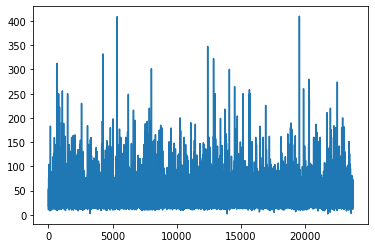

In [88]:
flats['living_area'].plot()

<div class="alert alert-info">
Выбросы мы рассматривали. Может, в комментарии имеются в виду квартиры с очень маленькой жилой площадью? Давайте их удалим. Самая маленькая площадь квартиры в Санкт-Петербурге в базе Циан - 8 кв.м. Удалим столбцы с площадью меньше
</div>

In [89]:
flats.loc[flats['living_area'] < 8]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3242,7,4440000.0,41.0,2017-07-02T00:00:00,1,2.714098,17,3.0,17,False,False,False,11.0,0,Санкт-Петербург,19272.0,13073.0,0,NaN,0,NaN,216.0
13915,20,6350000.0,52.0,2018-02-06T00:00:00,2,3.000000,6,2.0,2,False,False,False,9.0,0,Санкт-Петербург,32453.0,6521.0,0,NaN,1,1012.0,91.0
16431,13,3799000.0,31.0,2018-04-12T00:00:00,1,2.600000,5,6.0,1,False,False,False,17.0,0,Санкт-Петербург,32177.0,4826.0,1,430.0,0,NaN,168.0
17582,11,2680000.0,22.0,2018-08-11T00:00:00,0,2.777174,25,5.0,8,False,True,False,8.5,2,Санкт-Петербург,22735.0,11618.0,1,835.0,1,652.0,70.0
19251,19,4050000.0,33.0,2018-10-15T00:00:00,1,2.500000,22,6.5,21,False,False,False,18.0,0,Санкт-Петербург,9258.0,10592.0,1,458.0,0,NaN,44.0
21758,0,2330000.0,23.0,2018-01-01T00:00:00,0,2.854095,24,2.0,22,False,True,False,10.5,0,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,66.0
21943,15,6100000.0,77.6,2019-02-28T00:00:00,4,2.500000,9,5.4,1,False,False,False,9.8,0,Санкт-Петербург,29338.0,11270.0,1,584.0,0,NaN,33.0
23574,14,64990000.0,139.0,2015-11-24T00:00:00,3,3.000000,8,3.0,8,False,False,False,16.0,1,Санкт-Петербург,33255.0,5975.0,1,630.0,3,100.0,280.0


In [90]:
flats = flats.query('living_area >= 8')

In [144]:
flats.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m,weekday,month,year,cityCenters_nearest_km
count,23285.000000,2.328500e+04,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,17837.000000,17860.000000,23285.000000,7938.000000,23285.000000,8969.000000,20178.000000,2.328500e+04,23285.000000,23285.000000,23285.000000,17860.000000
mean,9.835817,6.478848e+06,60.227599,2.064119,2.741598,10.634271,34.235852,5.863732,10.756302,0.522053,28771.315356,14178.001904,0.470260,489.946586,0.592570,517.988182,180.948558,9.913693e+04,2.570797,6.402276,2017.364612,14.170997
std,5.667425,9.380688e+06,35.889083,1.082082,0.232539,6.590090,21.806418,4.868546,7.147737,0.805142,12634.323695,8631.163298,0.750613,342.203413,0.885124,277.623629,220.046028,4.666941e+04,1.787362,3.491621,1.040299,8.638757
min,0.000000,4.300000e+05,12.000000,0.000000,1.000000,1.000000,8.000000,1.000000,0.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,1.118349e+02,0.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.599169,5.000000,18.300000,2.000000,7.000000,0.000000,18582.000000,9176.000000,0.000000,287.000000,0.000000,294.000000,45.000000,7.657658e+04,1.000000,3.000000,2017.000000,9.000000
50%,9.000000,4.600000e+06,51.700000,2.000000,2.710758,9.000000,30.100000,4.000000,9.200000,0.000000,26634.000000,13088.000000,0.000000,453.000000,0.000000,502.000000,95.000000,9.495549e+04,3.000000,6.000000,2017.000000,13.000000
75%,14.000000,6.740000e+06,69.100000,3.000000,2.781679,16.000000,42.500000,8.000000,12.000000,1.000000,37242.000000,16293.000000,1.000000,611.000000,1.000000,728.000000,232.000000,1.140940e+05,4.000000,10.000000,2018.000000,16.000000
max,50.000000,4.200000e+08,900.000000,19.000000,6.000000,60.000000,409.700000,33.000000,238.250000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,1.000748e+06,6.000000,12.000000,2019.000000,66.000000


<font color='blue'>Добавим в датасет столбец <b>price_m</b>, разделив цену на площадь</font>

In [91]:
flats['price_m'] = flats['last_price'] / flats['total_area']

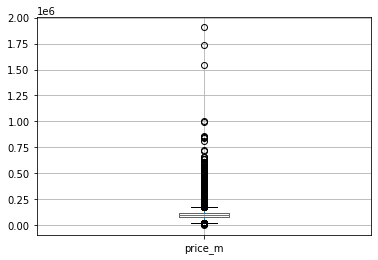

In [92]:
flats.boxplot('price_m')
plt.show()

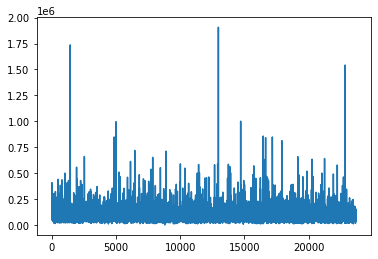

In [93]:
flats['price_m'].plot()
plt.show()

<div class="alert alert-info">
Есть три сильных выброса
</div>

In [94]:
flats['price_m'].describe()

count    2.328500e+04
mean     9.933742e+04
std      5.022337e+04
min      1.118349e+02
25%      7.657658e+04
50%      9.495549e+04
75%      1.140940e+05
max      1.907500e+06
Name: price_m, dtype: float64

<font color='blue'>Посмотрим на эти три аномальных значения</font>

In [95]:
flats.loc[flats['price_m'] > 1500000, ['last_price','total_area','cityCenters_nearest','rooms']]

,last_price,total_area,cityCenters_nearest,rooms
1436,330000000.0,190.0,1197.0,3
12971,763000000.0,400.0,3956.0,7
22831,289238400.0,187.5,1073.0,2


<font color='blue'>Опять выходит эта квартира с аномальной ценой. Разделим её цену и других двух квартир на 10, так будет более правдоподобно</font>

In [96]:
flats.loc[flats['price_m'] > 1500000, 'last_price'] =\
flats.loc[flats['price_m'] > 1500000, 'last_price']/10

In [97]:
flats['price_m'] = flats['last_price'] / flats['total_area']

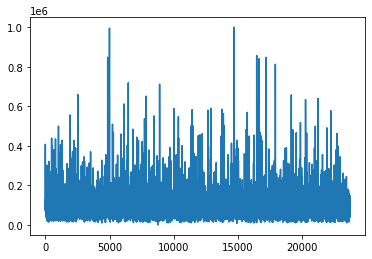

In [98]:
flats['price_m'].plot()
plt.show()

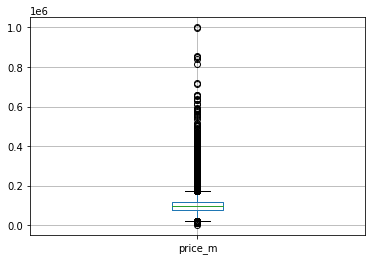

In [99]:
flats.boxplot('price_m')
plt.show()

<font color='blue'>Теперь рассмотрим маленькие значения</font>

In [100]:
flats.loc[flats['price_m'] < 10000, ['last_price','total_area','cityCenters_nearest','rooms','locality_name']]

,last_price,total_area,cityCenters_nearest,rooms,locality_name
4405,500000.0,52.0,NaN,2,Сланцы
8793,12190.0,109.0,9176.0,2,Санкт-Петербург
14911,430000.0,54.0,NaN,2,посёлок станции Свирь


<font color='blue'>Первая и третья вполне могут стоить так мало, они далеко в области, двухкомнатные, с относительно небольшой площадью. А вот вторая явно должна стоить не 12тыс, а 12млн. Поправим это</font>

In [101]:
flats.loc[8793,'last_price'] = flats.loc[8793,'last_price']*1000
flats.loc[8793,'last_price']

12190000.0

<font color='blue'>Добавим в таблицу столбец <b>weekday</b>, для этого обработаем столбец <b>first_day_exposition</b></font>

In [102]:
flats['first_day_exposition'].head()

0    2019-03-07T00:00:00
1    2018-12-04T00:00:00
2    2015-08-20T00:00:00
3    2015-07-24T00:00:00
4    2018-06-19T00:00:00
Name: first_day_exposition, dtype: object

<font color='blue'>Переведем его в формат datetime</font>

In [103]:
flats['first_day_exposition'] = pd.to_datetime(flats['first_day_exposition'], format = '%Y.%m.%dT%H:%M:%S', infer_datetime_format=True)

In [104]:
flats['first_day_exposition'].head()

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

<font color='blue'>Присвоим каждому дню недели в столбце номера</font>

In [105]:
flats['weekday'] =  flats['first_day_exposition'].dt.dayofweek

In [106]:
flats['weekday'].head(10)

0    3
1    1
2    3
3    4
4    1
5    0
6    3
7    3
8    2
9    6
Name: weekday, dtype: int64

<font color='blue'>Создадим столбцы <b>month</b>, <b>year</b></font>

In [107]:
flats['month'] = pd.to_datetime(flats['first_day_exposition'])
flats['month'] = flats['month'].dt.month

In [108]:
flats['year'] = pd.to_datetime(flats['first_day_exposition'])
flats['year'] = flats['year'].dt.year

In [109]:
flats.loc[:,['first_day_exposition', 'year', 'month']].head()

,first_day_exposition,year,month
0,2019-03-07,2019,3
1,2018-12-04,2018,12
2,2015-08-20,2015,8
3,2015-07-24,2015,7
4,2018-06-19,2018,6


<font color='blue'>Добавим в таблицу столбец <b>floor_type</b></font>

In [110]:
flats.loc[:,['floors_total', 'floor']].head(15)

,floors_total,floor
0,16,8
1,11,1
2,5,4
3,14,9
4,14,13
5,12,5
6,26,6
7,24,22
8,27,26
9,9,7


In [111]:
flats.loc[flats['floor'] == flats['floors_total'],'floor_type'] = 'последний'
flats.loc[flats['floor'] == 1,'floors_type'] = 'первый'
flats.loc[((flats['floor'] != flats['floors_total'])&(flats['floor'] != 1)),'floor_type'] = 'другой'

In [112]:
flats.loc[:,['floor','floors_total', 'floor_type']].head(10)

,floor,floors_total,floor_type
0,8,16,другой
1,1,11,NaN
2,4,5,другой
3,9,14,другой
4,13,14,другой
5,5,12,другой
6,6,26,другой
7,22,24,другой
8,26,27,другой
9,7,9,другой


Не понимаю, почему не работает "первый", поэтому заменила пропущенные в следующем коде

In [113]:
flats.loc[flats['floor_type'].isna(), ['floor','floor_type']]

,floor,floor_type
1,1,NaN
14,1,NaN
16,1,NaN
24,1,NaN
28,1,NaN
...,...,...
23665,1,NaN
23673,1,NaN
23680,1,NaN
23696,1,NaN


In [114]:
flats['floor_type'] = flats['floor_type'].fillna('первый')

In [115]:
flats.loc[:,['floor','floors_total', 'floor_type']].head(15)

,floor,floors_total,floor_type
0,8,16,другой
1,1,11,первый
2,4,5,другой
3,9,14,другой
4,13,14,другой
5,5,12,другой
6,6,26,другой
7,22,24,другой
8,26,27,другой
9,7,9,другой


<font color='blue'>Добавим в таблицу столбец <b>cityCenters_nearest_km</b></font>

In [116]:
flats['cityCenters_nearest_km'] = round(flats['cityCenters_nearest']/1000)

In [117]:
flats.loc[:,['cityCenters_nearest_km', 'cityCenters_nearest']].head()

,cityCenters_nearest_km,cityCenters_nearest
0,16.0,16028.0
1,19.0,18603.0
2,14.0,13933.0
3,7.0,6800.0
4,8.0,8098.0


### Исследовательский анализ данных

Изучите следующие параметры объектов:
общая площадь;
жилая площадь;
площадь кухни;
цена объекта;
количество комнат;
высота потолков;
этаж квартиры;
тип этажа квартиры («первый», «последний», «другой»);
общее количество этажей в доме;
расстояние до центра города в метрах;
расстояние до ближайшего аэропорта;
расстояние до ближайшего парка;
день и месяц публикации объявления.
Постройте отдельные гистограммы для каждого из этих параметров. Опишите все ваши наблюдения по параметрам в ячейке с типом markdown.

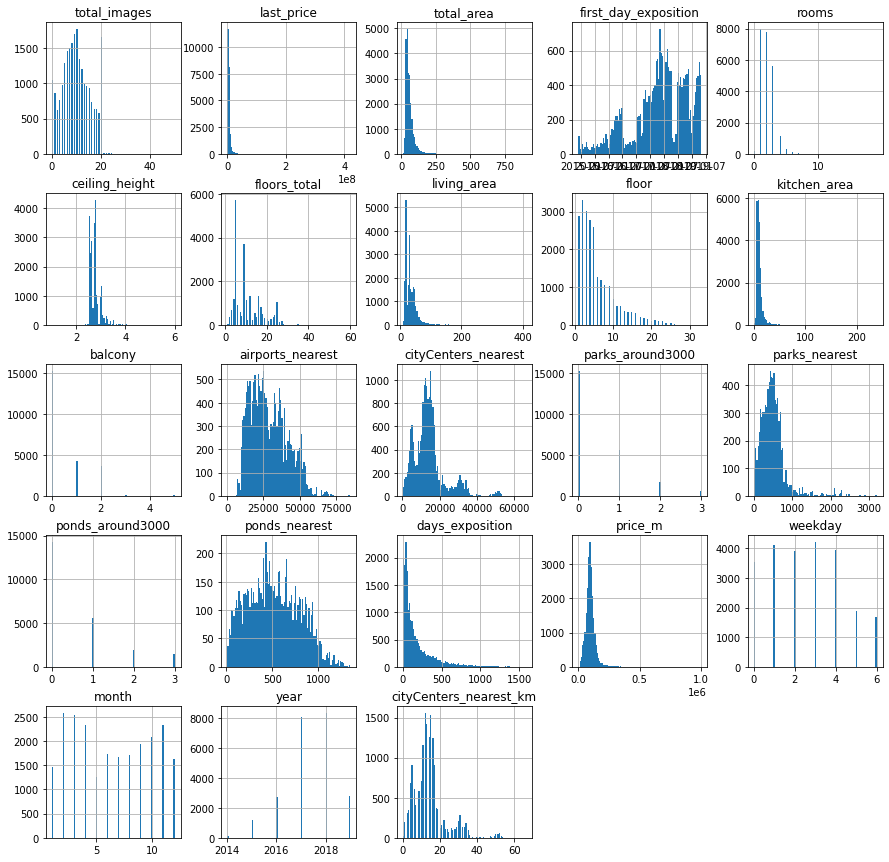

In [118]:
flats.hist(bins = 100, figsize = (15,15))
plt.show()

<AxesSubplot:>

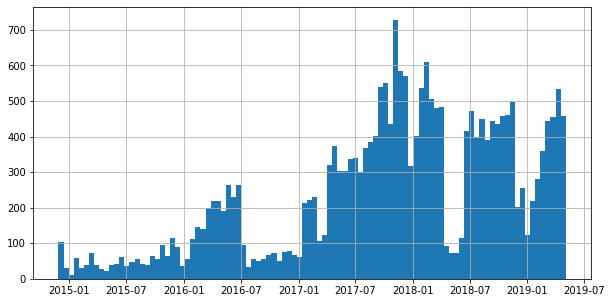

In [119]:
flats['first_day_exposition'].hist(bins=100, figsize = (10,5))

<AxesSubplot:>

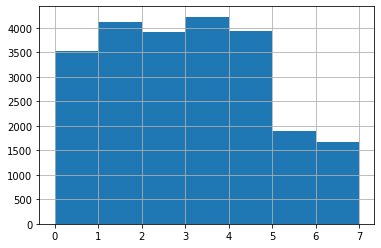

In [120]:
flats['weekday'].hist(bins=7, range = (0,7))

<AxesSubplot:>

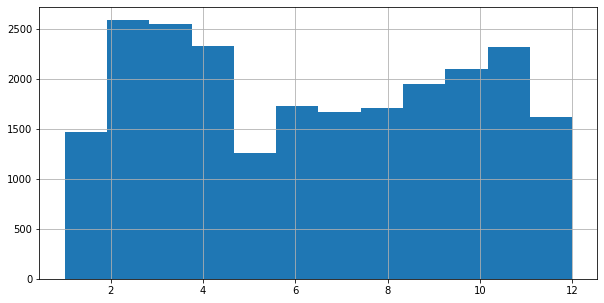

In [121]:
flats['month'].hist(figsize= (10,5),bins=12, range= (1,12))

<AxesSubplot:>

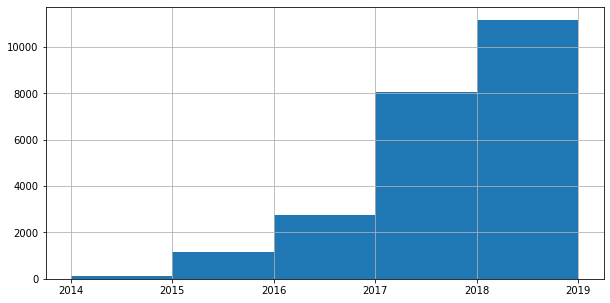

In [122]:
flats['year'].hist(bins = 5, figsize= (10,5))

<div class="alert alert-info">
<b>total_images:</b> Больше всего объявлений с фото от 0 до 20 (распределение близко к нормальному), есть выброс в районе 20 штук.
    <br/>
Столбец <b>last_price</b> очень размашистый, видно, что основная часть значений расположилась в начале графика. Но мы сократили количество выбросов
        <br/>
<b>total_area</b> выглядит как нормальное, больше всего продается квартир с не очень большй площадью
    <br/>
<b>rooms:</b> Видно, что больше всего продается одно-, двух- и трехкомнатных квартир, но есть и квартиры с большим количеством комнат
    <br/>
<b>ceiling_height</b> - основная часть значений лежит в районе 2.5-4м
   <br/>
<b>floors_total</b> - больше всего продают квартир в 5- и 9-этажках
    <br/>
    <b>floor:</b> - больше всего продаётся квартир на 1-5 этажах, меньше на 6-10, ещё меньше на 11-25, остальное - единичные значения. Наверное, активно продают квартиры в старых пятиэтажках
    <br/>
<b>living_area</b>, <b>kitchen_area</b> - здесь нормальное распределение, больше всего продается квартир с площадью до 100м
    <br/>
<b>balcony</b> - в основном в квартирах 1 балкон или нет балконов совсем
    <br/>  
<b>airports_nearest</b>, <b>cityCenters_nearest</b>, <b>parks_nearest</b>, <b>ponds_nearest</b> - тут приближенные к нормальным распределения
    <br/>
<b>parks_around3000</b>, <b>ponds_around3000</b> - в основном либо нет парков поблизости, либо сразу 2 или 3. Странно, что почти нет 1 в столбце с парками. В столбце с прудами примерно равномерное распределение, но почти нет такого, что поблизости нет прудов совсем
    <br/>
<b>days_exposition</b> - нормальное распределение, выбросы есть (а может, это просто очень долгие продажи)
    <br/>
<b>first_day_exposition</b> - больше всего продавалось крватир в конце 2017 года, а провалы - во второй половине 2016 и мае 2018, возможно, это связано с кризисами
    <br/>
<b>price_m</b> - цена нормально распределена
    <br/>
<b>weekday</b> - в выходные квартиры выставляются намного реже, чем в будние дни, а в четверг активнее всего
    <br/>
<b>month</b> - квартир выставляется больше всего в феврале, меньше - в мае
    <br/>
<b>year</b> - с каждым годом продается всё больше и больше квартир
     <br/>
<b>cityCenters_nearest_km</b> - больше всего продается квартир в Санкт-Петербурге (до 20км от центра), меньше - до 40км от центра, то есть окраины и пригород, и есть небольшой подъём в районе 50км, это ближайшие к Спб городки в области
   
</div>

<font color='blue'>Исследуем столбец <b>days_exposition</b></font>

In [123]:
flats['days_exposition'] = pd.to_numeric(flats['days_exposition'])
round(flats['days_exposition'], 2)

0          NaN
1         81.0
2        558.0
3        424.0
4        121.0
         ...  
23694      NaN
23695     45.0
23696      NaN
23697    602.0
23698      NaN
Name: days_exposition, Length: 23285, dtype: float64

<AxesSubplot:>

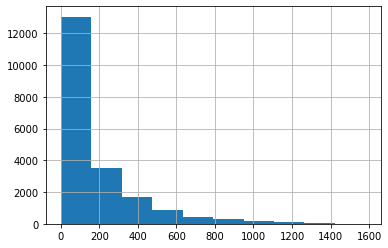

In [124]:
flats['days_exposition'].hist()

In [125]:
flats['days_exposition'].mean()

180.94855783526614

In [126]:
flats['days_exposition'].median()

95.0

<font color='blue'>Среднее значение сильно отличается от медианы, значит, много выбросов, посмотрим их</font>

In [127]:
flats['days_exposition'].sort_values(ascending=False).head(30)

18843    1580.0
1109     1572.0
9553     1553.0
1885     1513.0
20969    1512.0
6691     1512.0
14093    1497.0
15313    1489.0
19123    1485.0
11955    1484.0
4736     1477.0
2941     1458.0
6006     1452.0
521      1441.0
9555     1434.0
14873    1430.0
11985    1417.0
20996    1413.0
6726     1406.0
18262    1396.0
3725     1395.0
10364    1391.0
12047    1375.0
16169    1375.0
4110     1373.0
12201    1368.0
18848    1365.0
12209    1363.0
11421    1362.0
17930    1361.0
Name: days_exposition, dtype: float64

In [128]:
flats['days_exposition'].sort_values(ascending=True).head(30)

1632     1.0
16053    2.0
16212    2.0
13061    2.0
6238     3.0
16634    3.0
952      3.0
22127    3.0
7029     3.0
23394    3.0
20415    3.0
5163     3.0
10426    3.0
5060     3.0
12333    3.0
12357    3.0
7504     3.0
18866    3.0
16010    3.0
9186     3.0
12374    3.0
4937     3.0
19897    3.0
16126    3.0
1501     3.0
16589    3.0
6909     3.0
19917    3.0
18057    3.0
2351     3.0
Name: days_exposition, dtype: float64

<font color='blue'>Продажи по 1500 дней - это больше 4 лет, думаю, если квартира продаётся больше года, это можно назвать долгой продажей
<br>
2-4 дня можно считать быстрыми, есть даже одна продажа за 1 день</font>

<font color='blue'>ЗАДАНИЕ 1: 
<br>
    Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год); </font>

<font color='blue'>Зависимость цены от общей площади, жилой площади, площади кухни и количества комнат в квартире </font>

In [129]:
area_price = flats.pivot_table(index = 'last_price', values = ['total_area', 'living_area','kitchen_area', 'rooms'], aggfunc = 'median')
area_price

,kitchen_area,living_area,rooms,total_area
last_price,,,,
430000.0,8.875,23.25,1.5,42.20
440000.0,11.200,17.60,1.0,40.00
450000.0,5.650,26.65,2.0,40.25
470000.0,9.000,28.00,1.0,41.00
480000.0,8.000,16.00,1.0,32.00
...,...,...,...,...
240000000.0,40.000,218.00,6.0,410.00
245000000.0,29.800,182.80,6.0,285.70
300000000.0,70.000,258.00,7.0,618.00


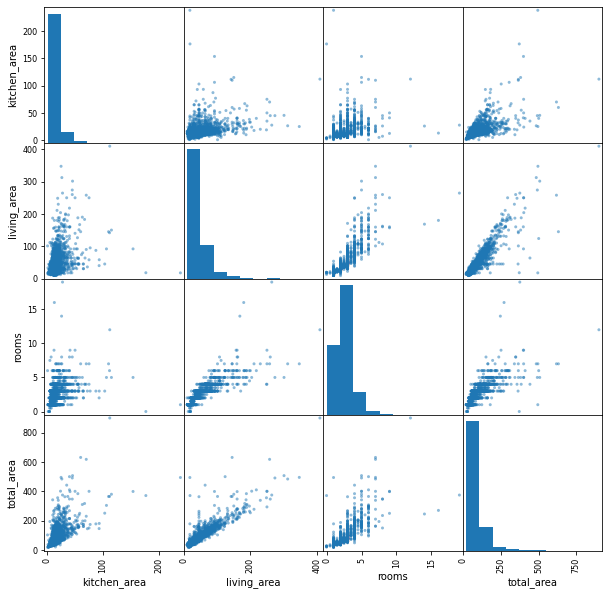

In [130]:
pd.plotting.scatter_matrix(area_price, figsize = (10,10))
plt.show()

<font color='blue'>По гистограммам видно, что больше продается квартир с общей площадью до 200кв.м., с жилой площадью до 100 кв.м., с площадью кухни до 50 кв.м., остальное выбросы.
<br>
По диаграмма рассеяния видно, что есть прямая зависимость цены от всех этих параметров, с корреляцией близкой к единице</font>

<font color='blue'>Зависимость цены от типа этажа </font>

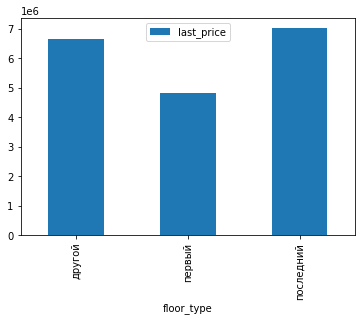

In [131]:
floor_price = flats.pivot_table(index = 'floor_type', values = 'last_price', aggfunc = 'mean')
floor_price.plot.bar()
plt.show()

<font color='blue'>Первый этаж дешевле, последний этаж дороже </font>

In [133]:
days_price = flats.pivot_table(index = 'last_price', values = ['weekday', 'month', 'year'])
days_price

,month,weekday,year
last_price,,,
430000.0,5.000000,0.50,2018.50
440000.0,7.000000,1.00,2018.00
450000.0,6.000000,2.25,2017.75
470000.0,3.666667,4.00,2018.00
480000.0,1.000000,6.00,2019.00
...,...,...,...
240000000.0,4.000000,5.00,2017.00
245000000.0,4.000000,0.00,2017.00
300000000.0,12.000000,0.00,2017.00


<div class="alert alert-info">
Зависимость цены от дня размещения
</div>

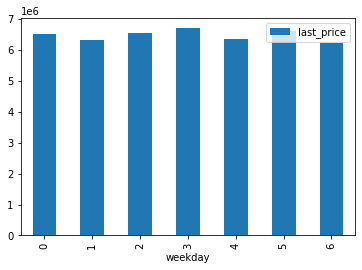

In [135]:
days_price = flats.pivot_table(index = 'weekday', values = 'last_price', aggfunc = 'mean')
days_price.plot.bar()
plt.show()

<div class="alert alert-info">
Цена, за которую в итоге купили квартиру, почти не зависит от дня размещения объявления. Чуть выше, чем в остальные дни, она в четверг.
</div>

<font color='blue'>ЗАДАНИЕ 2: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
</font>

In [136]:
top_localities = flats.value_counts('locality_name').head(10).index
top_localities

Index(['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары', 'Всеволожск',
       'Пушкин', 'Колпино', 'посёлок Парголово', 'Гатчина', 'деревня Кудрово',
       'Выборг'],
      dtype='object', name='locality_name')

<font color='blue'>Найдем эти населенные пункты в датасете
</font>

In [137]:
flats[flats['locality_name'].isin(top_localities)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m,weekday,month,year,floor_type,floors_type,cityCenters_nearest_km
0,20,13000000.0,108.00,2019-03-07,3,2.700000,16,51.0,8,False,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.370370,3,3,2019,другой,NaN,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.776981,11,18.6,1,False,False,False,11.00,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.792079,1,12,2018,первый,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.767439,5,34.3,4,False,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.714286,3,8,2015,другой,NaN,14.0
3,0,64900000.0,159.00,2015-07-24,3,2.735761,14,45.0,9,False,False,False,57.00,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176.100629,4,7,2015,другой,NaN,7.0
4,2,10000000.0,100.00,2018-06-19,2,3.030000,14,32.0,13,False,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.000000,1,6,2018,другой,NaN,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23689,13,3550000.0,35.30,2018-02-28,1,2.860000,15,16.3,4,False,False,False,9.10,2,Санкт-Петербург,17284.0,16081.0,1,353.0,2,652.0,29.0,100566.572238,2,2,2018,другой,NaN,16.0
23690,3,5500000.0,52.00,2018-07-19,2,2.767439,5,31.0,2,False,False,False,6.00,0,Санкт-Петербург,20151.0,6263.0,1,300.0,0,NaN,15.0,105769.230769,3,7,2018,другой,NaN,6.0
23691,11,9470000.0,72.90,2016-10-13,2,2.750000,25,40.3,7,False,False,False,10.60,1,Санкт-Петербург,19424.0,4489.0,0,NaN,1,806.0,519.0,129903.978052,3,10,2016,другой,NaN,4.0
23694,9,9700000.0,133.81,2017-03-21,3,3.700000,5,73.3,3,False,False,False,13.83,0,Санкт-Петербург,24665.0,4232.0,1,796.0,3,381.0,NaN,72490.845228,1,3,2017,другой,NaN,4.0


<font color='blue'>Посчитаем среднюю цену за квадратный метр в этих населенных пунктах
</font>

In [138]:
flats_top10 = (flats[flats['locality_name']
       .isin(top_localities)]
       .groupby('locality_name')
       .mean()
       .sort_values('price_m', ascending=False)
       .head(10))
flats_top10

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m,weekday,month,year,cityCenters_nearest_km
locality_name,,,,,,,,,,,,,,,,,,,,,,,,
Санкт-Петербург,10.146108,7.977731e+06,64.696232,2.168154,2.761170,11.336630,36.713044,6.205327,0.005495,0.002133,11.452013,0.510603,27996.159007,11569.777504,0.627166,497.460669,0.770365,520.182823,183.018683,114432.732641,2.557991,6.420934,2017.346263,11.563900
Пушкин,9.285714,6.451473e+06,61.392253,2.005495,2.756992,4.986264,34.514904,2.934066,0.000000,0.000000,11.020501,0.445055,16455.021978,28747.867769,0.736264,407.178744,0.865385,482.057471,209.181518,103085.250415,2.450549,6.170330,2017.230769,28.768595
деревня Кудрово,8.717687,4.223300e+06,46.254932,1.425170,2.729243,18.489796,23.743163,9.901361,0.020408,0.044218,10.919184,0.768707,NaN,NaN,0.000000,NaN,0.000000,NaN,182.734694,92706.904398,2.789116,6.421769,2016.908163,NaN
посёлок Парголово,8.694190,4.488075e+06,51.521407,1.605505,2.697343,22.070336,25.595688,12.015291,0.006116,0.009174,11.652003,0.697248,53994.926606,19924.776758,0.030581,501.100000,0.290520,598.071429,155.503311,90175.913458,2.648318,6.562691,2017.360856,19.948012
посёлок Мурино,8.490775,3.628817e+06,43.640793,1.381919,2.717839,19.562731,22.630959,10.850554,0.036900,0.012915,10.192961,0.690037,51553.000000,21888.000000,0.000000,NaN,0.007380,133.000000,149.130112,85744.419510,2.470480,6.832103,2017.374539,22.000000
посёлок Шушары,8.856813,4.096665e+06,53.599099,1.796767,2.699725,12.660508,28.988048,6.886836,0.009238,0.000000,10.762673,0.575058,16075.291375,24265.419580,0.000000,NaN,0.341801,578.047297,156.348259,78803.262065,2.718245,6.404157,2017.311778,24.223776
Колпино,8.851964,3.947264e+06,53.067795,2.117825,2.655012,8.815710,31.727553,4.818731,0.000000,0.003021,8.605740,0.558912,26376.600000,32113.478788,0.525680,497.587786,0.990937,534.053763,141.059603,75370.037054,2.489426,6.468278,2017.419940,32.039394
Гатчина,8.976431,3.463702e+06,50.622492,1.898990,2.723156,5.707071,29.551886,3.303030,0.000000,0.000000,8.308047,0.639731,NaN,NaN,0.000000,NaN,0.000000,NaN,190.833977,68712.843171,2.471380,6.080808,2017.279461,NaN
Всеволожск,10.167095,3.778712e+06,55.830925,1.897172,2.710640,8.367609,30.662571,4.614396,0.015424,0.000000,10.575874,0.632391,NaN,NaN,0.000000,NaN,0.000000,NaN,197.546547,68698.114075,2.516710,6.565553,2017.344473,NaN


<font color='blue'>В Санкт-Петербурге самые дорогие квадратные метры, это понятно. А в области самый дорогой город - Пушкин, а деревня - Кудрино. Самые бюджетные варианты можно найти во Всеволожске и Выборге
</font>

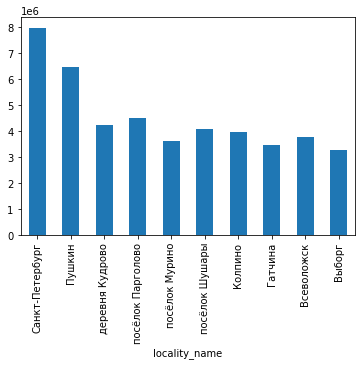

In [139]:
flats_top10['last_price'].plot.bar()
plt.show()

<font color='blue'>ЗАДАНИЕ 3: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.
</font>

In [141]:
fl = flats.pivot_table(index = 'cityCenters_nearest_km', values = 'last_price', aggfunc = ['mean','median'])
fl.head(10)

,mean,median
,last_price,last_price
cityCenters_nearest_km,,
0.0,3.144912e+07,17900000.0
1.0,1.827107e+07,11490000.0
2.0,1.776611e+07,10000000.0
3.0,1.110271e+07,8409000.0
4.0,1.227182e+07,9170000.0
5.0,1.451967e+07,9490000.0
6.0,1.525675e+07,8890000.0
7.0,1.482806e+07,7800000.0


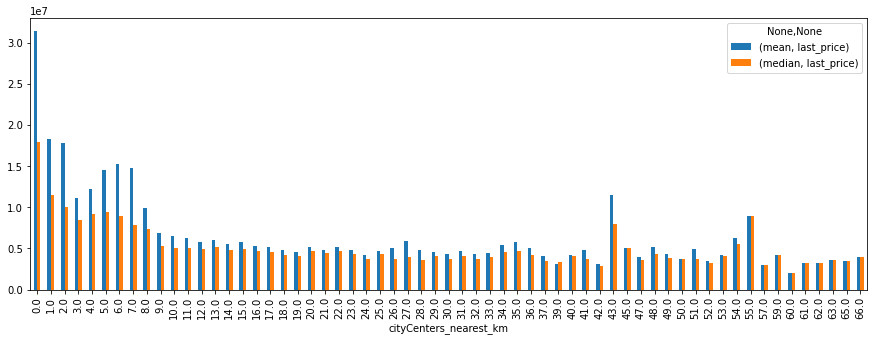

In [142]:
fl.plot.bar(figsize = (15,5))
plt.show()

<div class="alert alert-info">
Самые дорогие километры - в пределах 8км от центра, дальше цена ровная примерно от 9 до 66 километра с небольшим убыванием. Есть два всплеска на 43 и 55км, возможно, там какие-то особо комфортные условия проживания. И есть провал на 3-4 км, может, там промзона?
    <br>
Вплоть до 55км среднее значение превышает медианное. Это значит, что есть квартиры с завышенными ценами, которые выбиваются по цене в своей категории. Но цену владелец устанавливает сам, тут ничего не поделать.
    <br>  
    С 55 до 66 км среднее и медиана равные, там цены примерно в одном ценовом диапазоне.
</div>

# Общий вывод

<div class="alert alert-info">
В первую очередь при внимательном рассмотрении датасета нашли пропущенные значения в некоторых столбцах.
    <br/>
    
Заполнили там, где это возможно, например, в столбцах <b>balcony</b>, <b>is_apartment</b>,<b>parks_around3000</b> и <b>ponds_around3000</b> заменили отсутствующие значение на 0 или false.
    <br/>
    
В столбцах <b>living_area</b>, <b>ceiling_height</b> пропуски заполнили медианным значением по определенному признаку, <b>kitchen_area</b> вычислили из <b>total_area</b> и <b>living_area</b>, в <b>locality_name</b> заполнили некоторые строки по расстоянию до центра, пропущенные значения в <b>floors_total</b> (их было немного) заменили значением этажа квартиры <b>floor</b>.
<br/>
    
Пропущенные значения в столбцах <b>airports_nearest</b>, <b>cityCenters_nearest</b>, <b>parks_nearest</b>, <b>ponds_nearest</b> оставили, так как заменять их было некорректно.
<br/>
    
Далее рассмотрели типы данных в каждом столбце, изменили их, где было нужно.
<br/>
    
Изучили неявные дубликаты в столбце с названиями и устранили их. 
<br>
    
Устранили редкие и выбивающиеся значения в столбцах <b>living_area</b>, <b>ceiling_height</b>.
    <br>
    
    
Добавили в таблицу новые столбцы: <b>price_m</b> (цена одного квадратного метра), <b>weekday</b> (день недели публикации объявления), <b>month</b> (месяц публикации объявления), <b>year</b> (год публикации объявления),<b>floor_type</b> (тип этажа квартиры), <b>cityCenters_nearest_km</b> (расстояние до центра города в километрах).

<br/>
По гистограммам можно сказать, что большинство продающихся квартир - с площадью до 100м, средней ценой, и находящиеся в Санкт-Петербурге.
  <br>  
В основном продаются одно-, двух- и трехкомнатные квартиры, но есть и квартиры с большим количеством комнат
    <br/>
Больше всего продают квартир в 5- и 9-этажках, на 1-5 этажах, меньше на 6-10, ещё меньше на 11-25, в основном в квартирах 1 балкон или нет балконов совсем
    <br/>
Больше всего продавалось квартир в конце 2017 года, а провалы - во второй половине 2016 и мае 2018, возможно, это связано с кризисами.
        <br/>
В выходные квартиры выставляются намного реже, чем в будние дни, а в четверг активнее всего; меньше - в мае, больше - в феврале и с каждым годом продается всё больше и больше.
     <br/>

По диаграммам рассеяния видно, что есть прямая зависимость цены от общей площади, жилой площади, площади кухни, количества комнат.
         <br/>
Также цена зависит от этажа, на котором расположена квартира (первый этаж дешевле, последний этаж дороже)
         <br/>
Цена, за которую в итоге купили квартиру, почти не зависит от дня размещения объявления. Чуть выше, чем в остальные дни, она в четверг.
<br>
    
В Санкт-Петербурге самые дорогие квадратные метры, в области самый дорогой город - Пушкин, а деревня - Кудрино. Самые бюджетные варианты можно найти во Всеволожске и Выборге
<br>
    
Самые дорогие километры - в пределах 8км от центра, дальше цена ровная примерно от 9 до 66 километра с небольшим убыванием. Есть два всплеска на 43 и 55км, возможно, там какие-то особо комфортные условия проживания. И есть провал на 3-4 км, возможно, из-за промзоны.
    <br>
    
Также при покупке квартиры стоит следить за ценами на квартиры в похожих категориях, расположенными в пределах от 0 до 55км от центра города, там есть завышенные значения цены. После 55км цену владельцы практически не завышают.
</div>